# FISH integrated analyses

<img src= /home/luisub/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

In [1]:
# <img src= /Users/luisaguilera/Desktop/FISH_Processing/docs/code_architecture.png alt="drawing" width="1000"/>

## Libraries

In [2]:
# Importing libraries
import sys
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")

## Directories Path

In [3]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('MS2-Cy3')
data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('GAPDH_Exon_Cy5')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

2021-10-28 13:50:47,696 [INFO] WRITING LOG OUTPUT TO /home/luisub/.cellpose/run.log


## Loading Files

In [4]:
#list_file_names, list_images, number_images, output_to_path = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =0).merge()
list_images, path_files, list_files_names, number_images = fa.ReadImages(data_dir).read()

In [5]:
selected_image = 2

# Parameters for the pipeline

In [6]:
# Cell segmentation
channel_with_cytosol = [1,2]   # list or int
channel_with_nucleus = 0      # list or int
FISH_channel = [1]              # int specific channel with FISH spots that are used for the quantification
diamter_nucleus = 200         #approximated nucleus size in pixels
diameter_cytosol = 250        # approximated cytosol size in pixels

# Parameters for FISH detection
voxel_size_z = 300     # Height of a voxel, along the z axis, in nanometers. If None, image is considered in 2-d.
voxel_size_yx = 150    # Size of a voxel on the yx plan, in nanometers.
psf_z = 350            # Theoretical size of the PSF emitted by a spot in the z plan, in nanometers. If None, image is considered in 2-d.
psf_yx = 150           # Theoretical size of the PSF emitted by a spot in the yx plan, in nanometers.
# Cluster Detection
cluster_radius = 500     # The maximum distance between two samples for one to be considered as in the neighborhood of the other. Radius expressed in nanometer.
minimum_spots_cluster = 4   #The number of spots in a neighborhood for a point to be considered as a core point (from which a cluster is expanded). This includes the point itself.

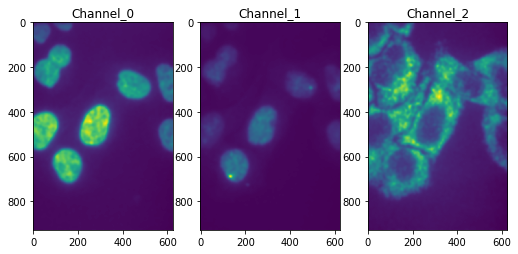

In [7]:
fa.PlotImages (list_images[selected_image],figsize=(8.5, 5) ).plot()

## Cell Segmentation

2021-10-28 13:50:54,119 [INFO] ** TORCH CUDA version installed and working. **
2021-10-28 13:50:54,120 [INFO] >>>> using GPU
2021-10-28 13:50:54,259 [INFO] ** TORCH CUDA version installed and working. **
2021-10-28 13:50:54,260 [INFO] >>>> using GPU
2021-10-28 13:50:54,307 [INFO] ~~~ FINDING MASKS ~~~
2021-10-28 13:50:54,893 [INFO] >>>> TOTAL TIME 0.59 sec
2021-10-28 13:50:54,900 [INFO] ~~~ FINDING MASKS ~~~
2021-10-28 13:50:55,322 [INFO] >>>> TOTAL TIME 0.42 sec
2021-10-28 13:50:55,327 [INFO] ~~~ FINDING MASKS ~~~
2021-10-28 13:50:55,768 [INFO] >>>> TOTAL TIME 0.44 sec
2021-10-28 13:50:55,777 [INFO] ~~~ FINDING MASKS ~~~
2021-10-28 13:50:56,196 [INFO] >>>> TOTAL TIME 0.42 sec
2021-10-28 13:50:56,201 [INFO] ~~~ FINDING MASKS ~~~
2021-10-28 13:50:56,612 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-28 13:50:56,617 [INFO] ~~~ FINDING MASKS ~~~
2021-10-28 13:50:57,057 [INFO] >>>> TOTAL TIME 0.44 sec
2021-10-28 13:50:57,059 [INFO] ** TORCH CUDA version installed and working. **
2021-10-28 13:50:

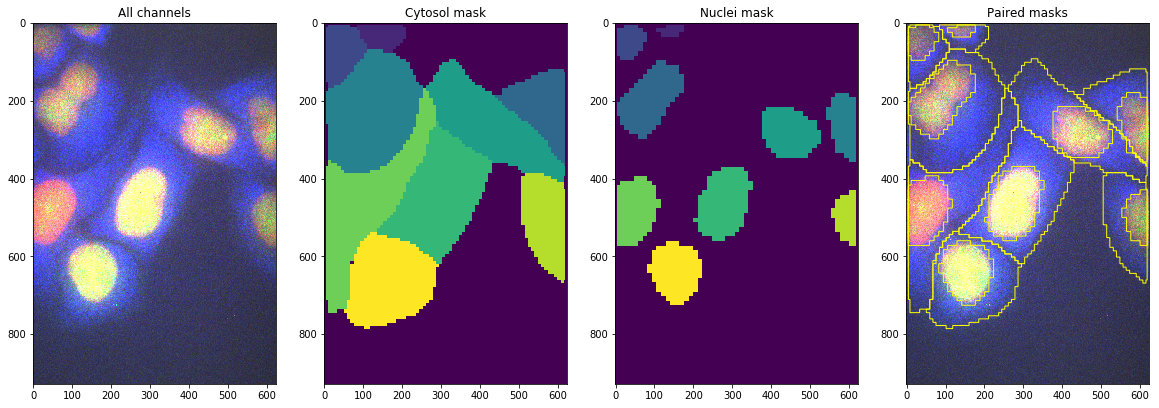

In [8]:
remove_fragmented_cells = False
masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, index_paired_masks = fa.CellSegmentation(list_images[selected_image],channel_with_cytosol=channel_with_cytosol, channel_with_nucleus=channel_with_nucleus,diameter_cytosol = diameter_cytosol, diamter_nucleus=diamter_nucleus,remove_fragmented_cells= remove_fragmented_cells, show_plot=1).calculate_masks() 

## Spot Detection

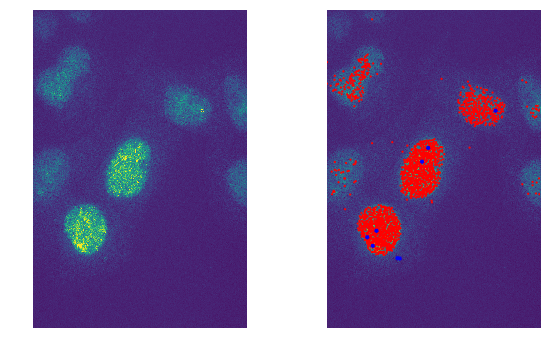

In [9]:
[spotDectionCSV, clusterDectionCSV] = fa.SpotDetection(list_images[selected_image],FISH_channel, voxel_size_z = voxel_size_z,voxel_size_yx = voxel_size_yx,psf_z = psf_z, psf_yx = psf_yx,cluster_radius=cluster_radius,minimum_spots_cluster=minimum_spots_cluster, show_plot=1).detect()

## Extracting data as a dataframe

In [10]:
dataframe_FISH = fa.DataProcessing(spotDectionCSV, clusterDectionCSV,masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, dataframe =None).get_dataframe()

In [11]:
dataframe_FISH.head()

,image_id,cell_id,spot_id,nucleus_y,nucleus_x,nuc_area_px,cyto_area_px,cell_area_px,z,y,x,is_nuc,is_cluster,cluster_size
0,0,0,0,19,143,1745,5108,6853,13,26,132,1,0,0
1,0,1,-1,47,38,5573,6984,12557,-1,-1,-1,0,0,0
2,0,2,0,260,587,10427,13396,23271,6,210,582,1,0,0
3,0,2,1,260,587,10427,13396,23271,6,313,608,1,0,0
4,0,2,2,260,587,10427,13396,23271,7,204,571,1,0,0


## Accessing data via conditional arguments

In [12]:
# all clusters in the data
#dataframe_FISH.loc[   (dataframe_FISH['is_nuc']==True) ]

In [13]:
# Number of cells
number_cells = dataframe_FISH['cell_id'].nunique()
# Number of spots
number_of_spots_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==False) & (dataframe_FISH['is_nuc']==True)  ].spot_id) for i in range(0, number_cells)]
# Number of TS per cell
number_of_TS_per_cell = [len( dataframe_FISH.loc[  (dataframe_FISH['cell_id']==i) &  (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  ].spot_id) for i in range(0, number_cells)]
# Number of RNA in a TS
ts_size =  dataframe_FISH.loc[   (dataframe_FISH['is_cluster']==True) & (dataframe_FISH['is_nuc']==True)  ].cluster_size.values
# Size of each cell
cell_size = dataframe_FISH.loc[  (dataframe_FISH['spot_id']==0)  ].cell_area_px.values

# Plotting results

In [14]:
fig_size = (20, 5)
f = plt.figure(figsize=fig_size)
def plot_probability_distribution(data_to_plot, numBins = 10, title='', xlab='', ylab='', color='r', subplots=False, show_grid=True, fig=f):

  def normalization_hist (data,numBins=10):
    results, edges = np.histogram(data,bins=numBins, normed=True)
    binWidth = edges[1] - edges[0]
    return edges, results, binWidth
  edges, results, binWidth = normalization_hist (data_to_plot,numBins)
  plt.bar(edges[:-1], results*binWidth, binWidth,color=color)
  plt.xlabel(xlab, size=16)
  plt.ylabel(ylab, size=16)
  plt.grid(show_grid)
  plt.title(title, size=16)
  return (f)

<Figure size 1440x360 with 0 Axes>

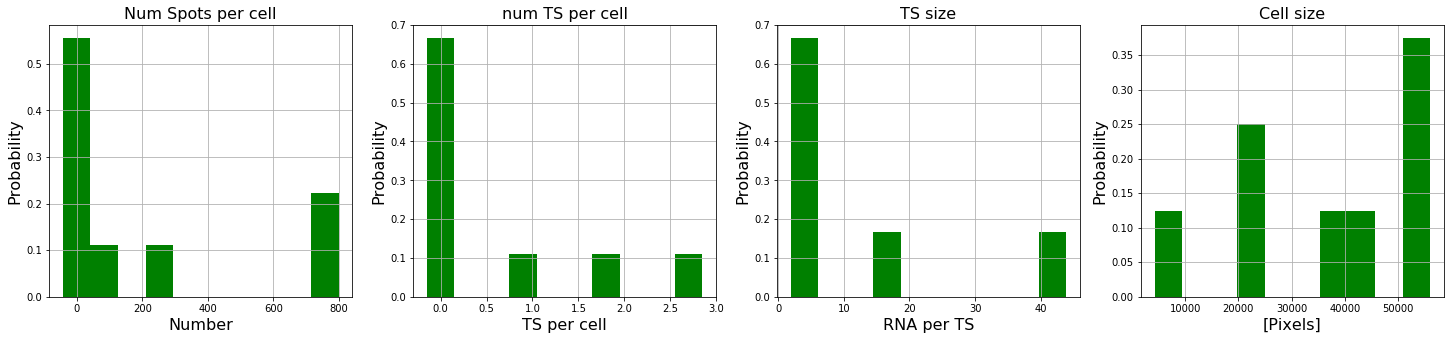

In [15]:
#Plotting
fig_size = (25, 5)
f = plt.figure(figsize=fig_size)
# adding subplots
f.add_subplot(1,4,1) 
plot_probability_distribution( number_of_spots_per_cell,   title='Num Spots per cell', xlab='Number', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,2) 
plot_probability_distribution(number_of_TS_per_cell,     title='num TS per cell', xlab='TS per cell', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,3) 
plot_probability_distribution(ts_size,     title='TS size', xlab='RNA per TS', ylab='Probability', fig=f, color='g')

f.add_subplot(1,4,4) 
plot_probability_distribution(cell_size  , title='Cell size', xlab='[Pixels]', ylab='Probability', fig=f, color='g')

# plt.savefig('./results/sim_intensity_dist_ch0.png')
plt.show()